In [1]:
import pandas as pd
from google.cloud import bigquery
from google.cloud.bigquery import job
from datetime import date, timedelta
# 판다스 엑셀 익스포트를 위한 라이브러리
import openpyxl


PROJECT = "ballosodeuk"
bq = bigquery.Client(project=PROJECT)

### 원본 데이터 로드.
- 25년 이전 가입자 쿼리로 컷.
- 첫구매 기준, 파이썬으로 최소 한달 전으로 최신 구매 컷 (2025-03-13 데이터 컷)
    - 결과적으로 2025-03-13 ~ 2025-04-25 데이터 컷

In [2]:
query = """
  WITH first_purchase AS (
    SELECT 
      user_id,
      MIN(register_dt) AS first_purchase_date
    FROM `dm.agg_user_cash_daily`
    WHERE purchase IS NOT NULL
    GROUP BY user_id
  ),

  second_purchase AS (
    SELECT 
      a.user_id,
      MIN(a.register_dt) AS second_purchase_date
    FROM `dm.agg_user_cash_daily` a
    JOIN first_purchase fp ON a.user_id = fp.user_id
    WHERE a.purchase IS NOT NULL
      AND a.register_dt > fp.first_purchase_date
    GROUP BY a.user_id
  ),

  final AS (
    SELECT DISTINCT 
      a.user_id,
      date_diff (current_date(), join_dt, day) as join_dt,
      b.register_dt AS p_date,
      b.current_shoji AS cur_shoji,
      b.current_cash AS cur_cash,
      b.pre_shoji AS pre_shoji,
      b.pre_cash AS pre_cash,
      b.purchase AS p_amt,
      b.spend_use - b.earn_recall - b.spend_burnt AS s_amt,
      ROUND(
        (b.spend_use - b.earn_recall - b.spend_burnt) / NULLIF(b.purchase, 0)
      , 2) AS s_rto,
      SUM(a.earn_exchange) OVER (
        PARTITION BY a.user_id
        ORDER BY a.register_dt
        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
      ) AS earn_exchange,
      COUNT(a.earn_exchange) OVER (
        PARTITION BY a.user_id
        ORDER BY a.register_dt
        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
      ) AS earn_exchange_cnt,
      SUM(a.earn_reward) OVER (
        PARTITION BY a.user_id
        ORDER BY a.register_dt
        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
      ) AS earn_reward,
      COUNT(a.earn_reward) OVER (
        PARTITION BY a.user_id
        ORDER BY a.register_dt
        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
      ) AS since_visit_dt,
      COUNT(CASE WHEN a.earn_reward > 0 THEN a.earn_reward END) OVER (
        PARTITION BY a.user_id
        ORDER BY a.register_dt
        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
      ) AS earn_reward_cnt
    FROM `dm.agg_user_cash_daily` a
    JOIN first_purchase fp ON a.user_id = fp.user_id
    JOIN `dm.agg_user_cash_daily` b 
      ON a.user_id = b.user_id 
      AND b.register_dt = fp.first_purchase_date
    JOIN `dw.dim_airbridge_member` c 
      ON a.user_id = c.user_id
    WHERE a.register_dt <= fp.first_purchase_date
      AND b.purchase IS NOT NULL
      AND c.join_dt < "2024-12-31"
  ),

  second_purchase_data AS (
    SELECT DISTINCT 
      a.user_id,
      s.second_purchase_date,
      b.current_shoji AS second_cur_shoji,
      b.pre_shoji AS second_pre_shoji,
      b.pre_cash AS second_pre_cash,
      b.purchase AS second_p_amt,
      b.spend_use - b.earn_recall - b.spend_burnt AS second_s_amt,
      ROUND(
        (b.spend_use - b.earn_recall - b.spend_burnt) / NULLIF(b.purchase, 0)
      , 2) AS second_s_rto,
      SUM(a.earn_exchange) OVER (
        PARTITION BY a.user_id
        ORDER BY a.register_dt
        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
      ) AS second_earn_exchange,
      COUNT(a.earn_exchange) OVER (
        PARTITION BY a.user_id
        ORDER BY a.register_dt
        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
      ) AS second_earn_exchange_cnt,
      SUM(a.earn_reward) OVER (
        PARTITION BY a.user_id
        ORDER BY a.register_dt
        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
      ) AS second_earn_reward,
      COUNT(a.earn_reward) OVER (
        PARTITION BY a.user_id
        ORDER BY a.register_dt
        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
      ) AS second_since_visit_dt,
      COUNT(CASE WHEN a.earn_reward > 0 THEN a.earn_reward END) OVER (
        PARTITION BY a.user_id
        ORDER BY a.register_dt
        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
      ) AS second_earn_reward_cnt
    FROM `dm.agg_user_cash_daily` a
    JOIN second_purchase s ON a.user_id = s.user_id
    JOIN first_purchase fp ON a.user_id = fp.user_id
    JOIN `dm.agg_user_cash_daily` b 
      ON a.user_id = b.user_id 
      AND b.register_dt = s.second_purchase_date
    WHERE a.register_dt > fp.first_purchase_date
      AND a.register_dt <= s.second_purchase_date
      AND b.purchase IS NOT NULL
  ),

  between_purchases AS (
    SELECT
      a.user_id,
      SUM(a.earn_exchange) AS between_earn_exchange,
      COUNT(a.earn_exchange) AS between_earn_exchange_cnt,
      SUM(a.earn_reward) AS between_earn_reward,
      COUNT(CASE WHEN a.earn_reward > 0 THEN a.earn_reward END) AS between_earn_reward_cnt,
      COUNT(a.register_dt) AS between_visit_cnt
    FROM `dm.agg_user_cash_daily` a
    JOIN first_purchase fp ON a.user_id = fp.user_id
    JOIN second_purchase sp ON a.user_id = sp.user_id
    WHERE a.register_dt > fp.first_purchase_date
      AND a.register_dt < sp.second_purchase_date
    GROUP BY a.user_id
  ),

  churn AS (
    SELECT 
      DISTINCT user_id, 
      is_churn
    FROM `dm.agg_user_churn_daily`
    WHERE is_churn IS TRUE
  )


  SELECT 
    a.*,
    CASE WHEN b.is_churn IS TRUE THEN TRUE ELSE FALSE END AS is_churn,
    s.second_purchase_date,
    s.second_cur_shoji,
    s.second_pre_shoji,
    s.second_pre_cash,
    s.second_p_amt,
    s.second_s_amt,
    s.second_s_rto,
    s.second_earn_exchange,
    s.second_earn_exchange_cnt,
    s.second_earn_reward,
    s.second_since_visit_dt,
    s.second_earn_reward_cnt,
    bp.between_earn_exchange,
    bp.between_earn_exchange_cnt,
    bp.between_earn_reward,
    bp.between_earn_reward_cnt,
    date_diff(s.second_purchase_date, a.p_date, day) AS days_between_purchases
  FROM (
    SELECT *
    FROM (
      SELECT *, ROW_NUMBER() OVER(PARTITION BY user_id ORDER BY earn_reward_cnt DESC) AS rnk
      FROM final
    )
    WHERE rnk = 1
  ) a
  LEFT JOIN churn b ON a.user_id = b.user_id
  LEFT JOIN (
    select *
    from(
        SELECT *, ROW_NUMBER() OVER(PARTITION BY user_id ORDER BY second_earn_reward_cnt DESC) AS rnk
        FROM second_purchase_data
      )
    where rnk = 1
  ) s ON a.user_id = s.user_id
  LEFT JOIN between_purchases bp ON a.user_id = bp.user_id
"""

In [ ]:
df = bq.query(query).to_dataframe()

In [33]:
from datetime import datetime as dt
ts = dt.today().strftime('%Y-%m-%d')
df.to_parquet(f'df_{ts}.parquet')


In [43]:
df = pd.read_parquet('C:\FTC_downloads\code\git\project_hct\/04-25\df_2025-04-17.parquet')

In [44]:
# 12/31 ~ 3/13 데이터 컷 (변수 삭제)
df['p_date'] = pd.to_datetime(df['p_date'])
df = df[(df['p_date'] > '2024-12-30') & (df['p_date'] <= '2025-03-13')]

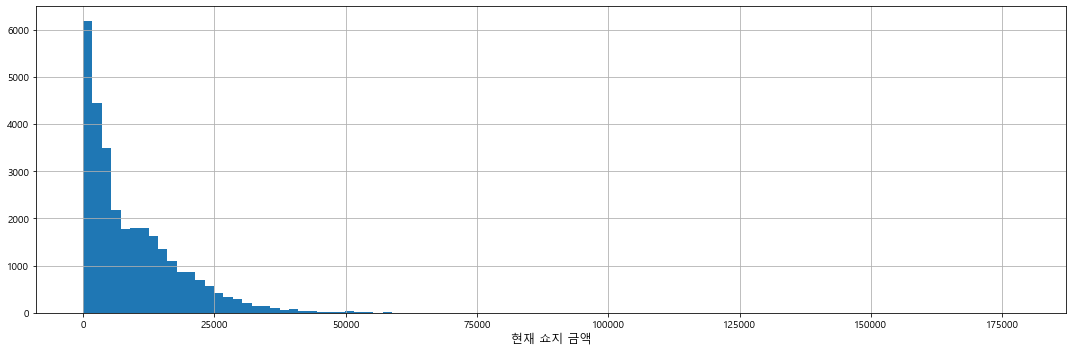

In [45]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import numpy as np
import pandas as pd

# 한글 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"  # 윈도우의 경우 맑은 고딕 폰트 경로
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 기존 히스토그램 그리기
plt.figure(figsize=(15, 5))
df.pre_shoji.hist(bins=100)
plt.xlabel('현재 쇼지 금액', fontsize=12)
plt.tight_layout()

## 소지 쇼지 기반 코호트 분석

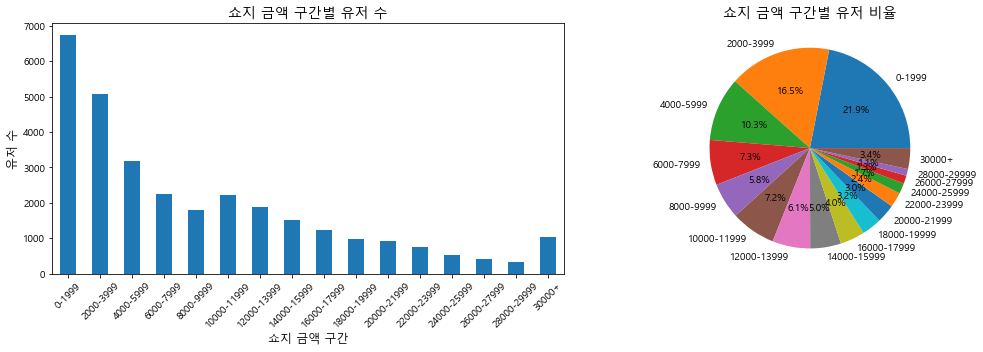

In [46]:
# pre_shoji를 2000 단위로 구간화하고, 3만 이상은 하나의 구간으로 통합
bins = list(range(0, 30001, 2000)) + [float('inf')]
labels = [f'{i}-{i+1999}' for i in range(0, 30000, 2000)] + ['30000+']

# 구간화 및 각 구간별 유저 수 계산
df['pre_shoji_bin'] = pd.cut(df['pre_shoji'], bins=bins, labels=labels, right=False)
bin_counts = df['pre_shoji_bin'].value_counts().sort_index()

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 첫 번째 그래프: 구간별 유저 수 막대 그래프
bin_counts.plot(kind='bar', ax=axes[0])
axes[0].set_title('쇼지 금액 구간별 유저 수', fontsize=14)
axes[0].set_xlabel('쇼지 금액 구간', fontsize=12)
axes[0].set_ylabel('유저 수', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# 두 번째 그래프: 구간별 유저 비율 파이 차트
bin_counts.plot(kind='pie', ax=axes[1], autopct='%1.1f%%')
axes[1].set_title('쇼지 금액 구간별 유저 비율', fontsize=14)
axes[1].set_ylabel('')

plt.tight_layout()


In [47]:
df['p_date'] = pd.to_datetime(df.p_date)
df.query("p_date >= '2025-01-01'").groupby('pre_shoji_bin').agg({
    'user_id': 'count',
    'pre_shoji': 'mean',
    'p_amt': 'mean',
    's_amt': 'mean',
    's_rto': 'mean',
    'earn_exchange': 'mean',
    'earn_reward': 'mean',
    # 'earn_reward_cnt': 'mean',
    'earn_reward_cnt': 'median',
    })


,user_id,pre_shoji,p_amt,s_amt,s_rto,earn_exchange,earn_reward,earn_reward_cnt
pre_shoji_bin,,,,,,,,
0-1999,6583,771.94106,15990.650160,2566.502355,0.257790,1530.482151,815.594562,15.0
2000-3999,5056,2986.77235,9997.897547,4236.930182,0.573734,2522.818631,2280.920293,31.0
4000-5999,3142,4949.440165,9064.847231,5598.914386,0.753205,4136.798218,2181.560789,30.0
6000-7999,2218,6977.018034,10505.189360,6939.034265,0.783327,5695.602344,2091.983769,31.0
8000-9999,1762,8968.698638,11633.019296,8769.167991,0.830499,7682.579455,2180.109535,34.0
10000-11999,2186,10923.768984,13662.593779,11029.327081,0.866377,10479.830284,1740.87054,29.0
12000-13999,1859,12982.646046,14927.729962,12709.480366,0.896708,12517.381926,2398.091985,44.0
14000-15999,1500,14970.046667,16097.260000,14036.600667,0.919213,14054.159333,2504.737333,44.0
16000-17999,1211,16950.326177,17147.762180,15078.754748,0.918266,15713.365813,2502.037985,45.0


<Axes: >

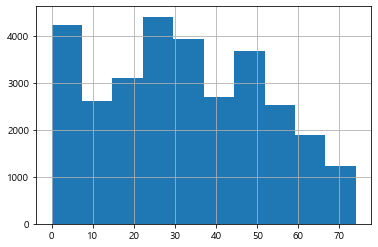

In [48]:
df.query("p_date >= '2025-01-01'").earn_reward_cnt.hist()

In [49]:
# BigQuery에서 가져온 데이터는 때때로 타입 문제가 발생할 수 있습니다.
# 'earn_reward_cnt' 열의 타입을 명시적으로 변환해 보겠습니다.
df['earn_reward_cnt'] = df['earn_reward_cnt'].astype(float)

# 참고: df = bq.query(query).to_dataframe()으로 BigQuery에서 데이터를 가져올 때
# 'unknown type object' 오류가 발생할 수 있습니다. 이는 pandas와 BigQuery 간의
# 데이터 타입 호환성 문제로 인한 것입니다.

In [50]:
df['pre_cash'] = df['pre_cash'].fillna(0)
# 5000 단위로 구간 설정
bins = list(range(0, 30001, 5000)) + [float('inf')]
labels = [f'{i}-{i+4999}' for i in range(0, 30000, 5000)] + ['30000+']

# pre_cash와 pre_shoji 모두 5000 단위로 구간화하고, 3만 이상은 하나의 구간으로 통합
df['pre_cash_bin'] = pd.cut(df['pre_cash'], bins=bins, labels=labels, right=False)
df['pre_shoji_bin'] = pd.cut(df['pre_shoji'], bins=bins, labels=labels, right=False)

In [51]:
df.groupby('pre_cash_bin').agg({
    'user_id': 'count',
    'is_churn': 'count',
    'pre_cash': 'mean',
    'pre_shoji': 'mean',
    'p_amt': 'mean',
    's_amt': 'mean',
    's_rto': 'mean',
    'earn_exchange': 'mean',
    'earn_reward': 'mean',
    'earn_reward_cnt': ['median','mean'],
    })


user_id is_churn      pre_cash     pre_shoji         p_amt  \
               count    count          mean          mean          mean   
pre_cash_bin                                                              
0-4999         18359    18359   1000.503513  12238.922164  14488.442726   
5000-9999       4211     4211   7187.997863   5985.515317  13511.918784   
10000-14999     3620     3620  12222.258840   4841.091713  14080.762431   
15000-19999     2297     2297  17283.696561   4322.490205  14146.538964   
20000-24999     1267     1267  22130.318074   4363.381215  15009.171271   
25000-29999      599      599  27152.624374   4325.517529  16368.080134   
30000+           434      434  36269.089862   4927.052995  19186.405530   

                     s_amt     s_rto earn_exchange  earn_reward  \
                      mean      mean          mean         mean   
pre_cash_bin                                                      
0-4999        10560.104962  0.762693  11126.821559  2181.289994   
5000-9999       6365.50938  0.559119   7103.751128  1690.548801   
10000-14999    7241.831768  0.602044   6727.199448  1884.575967   
15000-19999    5850.470178  0.541981   5187.824989  2040.463648   
20000-24999    5842.856354  0.542518   5090.066298  2129.273875   
25000-29999     5284.15025  0.511987   4662.111853   2142.60601   
30000+         5730.076037  0.515945   4810.571429  2320.705069   

             earn_reward_cnt             
                      median       mean  
pre_cash_bin                             
0-4999                  34.0  34.362275  
5000-9999               27.0  26.543339  
10000-14999             28.0  28.589227  
15000-19999             29.0  29.105355  
20000-24999             29.0  28.557222  
25000-29999             28.0  26.567613  
30000+                  28.0  25.887097

In [52]:
df.groupby('pre_shoji_bin').agg({
    'user_id': 'count',
    'is_churn': 'count',
    'pre_cash': 'mean',
    'pre_shoji': 'mean',
    'p_amt': 'mean',
    's_amt': 'mean',
    's_rto': 'mean',
    'earn_exchange': 'mean',
    'earn_reward': 'mean',
    'earn_reward_cnt': ['median','mean'],
    })


user_id is_churn     pre_cash     pre_shoji         p_amt  \
                count    count         mean          mean          mean   
pre_shoji_bin                                                             
0-4999          13392    13392  9890.531213   2035.696013  12937.554510   
5000-9999        5623     5623  5257.427885   7166.800285  10520.218744   
10000-14999      4867     4867  3439.261968  12280.850832  14514.561331   
15000-19999      2957     2957  2076.401759  17248.104498  17236.070342   
20000-24999      1946     1946  2019.301644  22218.921377  20296.145940   
25000-29999       973      973  1396.059609  27272.252826  22116.998972   
30000+           1033     1033  2364.028074   38274.03485  27595.914811   

                      s_amt     s_rto earn_exchange  earn_reward  \
                       mean      mean          mean         mean   
pre_shoji_bin                                                      
0-4999          3511.099686  0.432879   2147.033303  1553.934961   
5000-9999       7186.884937  0.789337   6038.796906  2036.113463   
10000-14999    12114.012739  0.886141  11812.312102  2112.645161   
15000-19999    15254.692594  0.923280  16225.027054  2526.596212   
20000-24999    18207.320658  0.933428  21414.619733  2831.808325   
25000-29999    20413.100719  0.947934  26512.673176  3375.463515   
30000+         25771.823814  0.953272  44693.116167  4709.725073   

              earn_reward_cnt             
                       median       mean  
pre_shoji_bin                             
0-4999                   26.0  25.329600  
5000-9999                30.0  32.268718  
10000-14999              37.0  34.969180  
15000-19999              45.0  39.502198  
20000-24999              48.0  41.916238  
25000-29999              51.0  47.063720  
30000+                   49.0  40.081317

In [53]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [54]:
# # 메모리 사용량 확인
# import psutil
# import os

# # 현재 프로세스의 메모리 사용량 확인
# process = psutil.Process(os.getpid())
# memory_info = process.memory_info()
# print(f"메모리 사용량: {memory_info.rss / 1024 / 1024:.2f} MB")

# # 시스템 전체 메모리 상태 확인
# system_memory = psutil.virtual_memory()
# print(f"시스템 전체 메모리: {system_memory.total / 1024 / 1024 / 1024:.2f} GB")
# print(f"사용 가능한 메모리: {system_memory.available / 1024 / 1024 / 1024:.2f} GB")
# print(f"메모리 사용률: {system_memory.percent}%")

# # CPU 사용량 확인
# cpu_percent = psutil.cpu_percent(interval=1)
# print(f"CPU 사용률: {cpu_percent}%")

# # 각 CPU 코어별 사용량
# cpu_percent_per_core = psutil.cpu_percent(interval=1, percpu=True)
# for i, percent in enumerate(cpu_percent_per_core):
#     print(f"CPU 코어 {i}: {percent}%")

메모리 사용량: 229.93 MB
시스템 전체 메모리: 31.77 GB
사용 가능한 메모리: 15.33 GB
메모리 사용률: 51.7%
CPU 사용률: 6.7%
CPU 코어 0: 26.2%
CPU 코어 1: 1.6%
CPU 코어 2: 24.6%
CPU 코어 3: 0.0%
CPU 코어 4: 21.2%
CPU 코어 5: 0.0%
CPU 코어 6: 28.4%
CPU 코어 7: 0.0%
CPU 코어 8: 23.1%
CPU 코어 9: 0.0%
CPU 코어 10: 29.2%
CPU 코어 11: 0.0%
CPU 코어 12: 19.7%
CPU 코어 13: 1.6%
CPU 코어 14: 0.0%
CPU 코어 15: 1.6%
CPU 코어 16: 20.3%
CPU 코어 17: 7.8%
CPU 코어 18: 4.8%
CPU 코어 19: 1.6%


In [ ]:
df.sample(1)

In [55]:
df['is_first_bankrupt'] = df.cur_shoji < 5
df[['is_first_bankrupt','cur_shoji','p_amt','s_amt']].sample(10)

,is_first_bankrupt,cur_shoji,p_amt,s_amt
39875,False,1652,10900.0,10900
36910,False,970,31100.0,31100
18575,False,213,21200.0,21200
46901,False,11,7800.0,390
1858,True,0,12600.0,3122
1824,False,15,5200.0,2741
40733,True,0,11900.0,10933
46032,False,11459,7900.0,7900
5925,False,12,3900.0,2915
15884,False,15,9900.0,3390


In [56]:
df.pre_cash_bin.unique()

['15000-19999', '5000-9999', '0-4999', '10000-14999', '20000-24999', '25000-29999', '30000+', NaN]
Categories (7, object): ['0-4999' < '5000-9999' < '10000-14999' < '15000-19999' < '20000-24999' < '25000-29999' < '30000+']

In [109]:
df.groupby(['pre_shoji_bin','pre_cash_bin']).agg({
    'join_dt': 'mean',
    'user_id': 'count',
    'is_first_bankrupt': 'sum',
    'is_churn': 'sum',
    "second_cur_shoji" :'count',
    'pre_cash': 'mean',
    'pre_shoji': 'mean',
    'p_amt': 'mean',
    's_amt': 'mean',
    's_rto': 'mean',
    'earn_exchange': 'mean',
    'earn_reward': 'mean',
    'earn_reward_cnt': 'mean',
    'second_pre_shoji':'mean',
    'second_pre_cash':'mean',
    'between_earn_reward_cnt':'mean',
    'between_earn_reward':'mean',
    'pre_asset':'mean',
    'second_pre_asset':'mean',
    "second_s_rto":'mean'
    }).reset_index()


,pre_shoji_bin,pre_cash_bin,join_dt,user_id,is_first_bankrupt,is_churn,second_cur_shoji,pre_cash,pre_shoji,p_amt,s_amt,s_rto,earn_exchange,earn_reward,earn_reward_cnt,second_pre_shoji,second_pre_cash,between_earn_reward_cnt,between_earn_reward,pre_asset,second_pre_asset,second_s_rto
0,0-4999,0-4999,552.971551,4675,2075,2497,1033,1782.311016,2168.705882,10801.302674,2635.038289,0.430650,1608.639786,1312.111016,24.052193,3622.629235,1016.050102,29.030832,1904.818088,3951.016898,4252.440695,0.528277
1,0-4999,5000-9999,569.094828,2784,1057,1093,1059,7223.963362,1698.599856,12412.076149,2922.744612,0.399389,1540.48204,1443.839799,24.591954,5011.180359,3264.902738,24.656313,1512.219439,8922.563218,8276.083097,0.572417
2,0-4999,10000-14999,579.934066,2548,956,857,990,12254.954474,1943.644427,13585.141287,4893.499215,0.486005,3246.040031,1655.428964,26.353611,7247.731313,5261.164646,24.351178,1509.337259,14198.598901,12508.89596,0.634303
3,0-4999,15000-19999,585.881908,1719,575,424,911,17289.778941,2181.765561,14350.459570,4250.04712,0.440471,2715.3153,1875.974404,27.871437,9192.221734,7785.147091,24.36899,1574.175481,19471.544503,16977.368825,0.667552
4,0-4999,20000-24999,589.784865,925,297,247,536,22110.710270,2157.547027,16061.740541,4314.417297,0.421481,2651.743784,1892.100541,27.259459,11260.992537,10297.162313,26.039832,1727.654088,24268.257297,21558.154851,0.696922
5,0-4999,25000-29999,598.587558,434,119,101,281,27154.205069,2250.347926,17938.525346,3758.292627,0.391406,2197.403226,1912.414747,24.746544,14252.224199,13204.092527,24.741573,1762.651685,29404.552995,27456.316726,0.700641
6,0-4999,30000+,597.74183,306,87,56,221,35380.816993,2337.098039,20518.660131,3805.947712,0.378007,1953.601307,2060.604575,23.728758,16856.538462,18569.479638,26.538835,2165.364078,37717.915033,35426.0181,0.654842
7,5000-9999,0-4999,562.390681,3906,1821,2123,525,859.796723,7316.322325,10411.323605,7133.695853,0.786324,5963.77957,1861.772401,32.695597,5142.615238,390.871094,28.97006,2037.530938,8176.119048,5402.410156,0.710114
8,5000-9999,5000-9999,562.227006,511,179,184,286,7337.688845,6725.117417,9959.608611,6808.242661,0.788630,5895.330724,2083.64775,28.473581,8800.758741,1390.709790,28.936842,2063.961404,14062.806262,10191.468531,0.814441
9,5000-9999,10000-14999,573.300216,463,139,111,270,12309.133909,6853.339093,11324.838013,7941.842333,0.790842,6904.064795,2421.866091,32.544276,11979.014815,2287.948148,27.751908,1870.251908,19162.473002,14266.962963,0.850741


In [58]:
df.columns

Index(['user_id', 'join_dt', 'p_date', 'cur_shoji', 'cur_cash', 'pre_shoji',
       'pre_cash', 'p_amt', 's_amt', 's_rto', 'earn_exchange',
       'earn_exchange_cnt', 'earn_reward', 'since_visit_dt', 'earn_reward_cnt',
       'rnk', 'is_churn', 'second_purchase_date', 'second_cur_shoji',
       'second_pre_shoji', 'second_pre_cash', 'second_p_amt', 'second_s_amt',
       'second_s_rto', 'second_earn_exchange', 'second_earn_exchange_cnt',
       'second_earn_reward', 'second_since_visit_dt', 'second_earn_reward_cnt',
       'between_earn_exchange', 'between_earn_exchange_cnt',
       'between_earn_reward', 'between_earn_reward_cnt',
       'days_between_purchases', 'pre_shoji_bin', 'pre_cash_bin',
       'is_first_bankrupt'],
      dtype='object')

In [59]:
df.columns

Index(['user_id', 'join_dt', 'p_date', 'cur_shoji', 'cur_cash', 'pre_shoji',
       'pre_cash', 'p_amt', 's_amt', 's_rto', 'earn_exchange',
       'earn_exchange_cnt', 'earn_reward', 'since_visit_dt', 'earn_reward_cnt',
       'rnk', 'is_churn', 'second_purchase_date', 'second_cur_shoji',
       'second_pre_shoji', 'second_pre_cash', 'second_p_amt', 'second_s_amt',
       'second_s_rto', 'second_earn_exchange', 'second_earn_exchange_cnt',
       'second_earn_reward', 'second_since_visit_dt', 'second_earn_reward_cnt',
       'between_earn_exchange', 'between_earn_exchange_cnt',
       'between_earn_reward', 'between_earn_reward_cnt',
       'days_between_purchases', 'pre_shoji_bin', 'pre_cash_bin',
       'is_first_bankrupt'],
      dtype='object')

In [104]:
df['pre_asset'] = df['pre_cash'] + df['pre_shoji']
df['second_pre_asset'] = df['second_pre_cash'] + df['second_pre_shoji']

df.groupby("earn_reward_cnt").agg({
    "user_id":'count',
    "pre_shoji":'mean',
    "pre_cash":"mean",
    "is_first_bankrupt":'sum',
    "is_churn":'sum',
    "second_cur_shoji":'count',
    "earn_reward":'mean',
    "earn_exchange":'mean',
    "p_amt":'mean',
    "s_amt":'mean',
    "s_rto":'mean',
    'second_pre_shoji':'mean',
    'second_pre_cash':'mean',
    'between_earn_reward_cnt':'mean',
    'between_earn_reward':'mean',
    'pre_asset':'mean',
    'second_pre_asset':'mean',
    "second_s_rto":'mean'
    }).reset_index()


,earn_reward_cnt,user_id,pre_shoji,pre_cash,is_first_bankrupt,is_churn,second_cur_shoji,earn_reward,earn_exchange,p_amt,s_amt,s_rto,second_pre_shoji,second_pre_cash,between_earn_reward_cnt,between_earn_reward,pre_asset,second_pre_asset,second_s_rto
0,0.0,372,6207.040323,3428.048387,266,335,46,0.0,8221.467742,14846.397849,7058.091398,0.574005,5370.021739,2597.681818,7.727273,482.30303,9635.08871,8005.363636,0.524348
1,1.0,792,8073.968434,4118.702020,276,576,181,478.670455,11391.969697,16759.823232,7850.958333,0.545960,7401.375691,4702.859649,22.045161,1447.954839,12192.670455,12323.894737,0.549613
2,2.0,835,8333.788024,6698.354491,243,468,288,719.05988,11854.051497,16808.323353,8035.032335,0.538623,8656.774306,6158.853571,28.633588,2592.156489,15032.142515,14165.385714,0.571736
3,3.0,662,7451.02568,6287.049849,178,381,233,605.706949,10228.410876,17082.567976,7321.273414,0.497689,6696.48927,6464.911504,23.425837,2432.373206,13738.075529,12813.004425,0.460472
4,4.0,567,7052.746032,6943.164021,168,340,188,398.061728,9648.708995,16937.601411,7028.989418,0.518395,6689.702128,7230.951872,26.072289,2093.578313,13995.910053,13929.962567,0.541543
5,5.0,512,7188.8125,7034.546875,157,284,164,642.085938,9112.582031,16575.722656,7166.070312,0.493633,7381.146341,6768.401235,23.328767,2459.472603,14223.359375,13881.351852,0.457500
6,6.0,495,7581.838384,7820.701010,143,255,187,745.862626,9897.494949,17335.212121,7351.523232,0.496808,7210.224599,8175.913514,31.059524,2438.982143,15402.539394,15159.264865,0.503957
7,7.0,460,6725.9,7303.193478,153,230,161,577.715217,8657.891304,16011.891304,6643.593478,0.486891,7537.496894,7414.980892,27.641892,2048.695946,14029.093478,14562.33758,0.557950
8,8.0,351,6602.692308,7460.729345,97,195,130,732.911681,8047.159544,16536.524217,6653.336182,0.522365,7561.084615,6998.476562,24.130435,1834.53913,14063.421652,14442.4375,0.540615
9,9.0,367,5836.359673,7301.446866,124,191,117,645.967302,7020.386921,17089.455041,6309.904632,0.504387,5886.709402,6598.121739,22.083333,1250.333333,13137.80654,12513.46087,0.547692


In [80]:
df.query('earn_reward_cnt >= 27 & earn_reward_cnt <= 35').s_rto.value_counts()

 1.00    1839
 0.05     284
 0.00     102
 0.18      62
 0.15      61
         ... 
 0.03      12
 0.02       9
 0.01       2
-0.01       1
-1.05       1
Name: s_rto, Length: 103, dtype: int64

#### 리워드 축적, 첫 구매까지 삼각분포를 이룸. 바로 사용은 이탈하는 특수 케이스로 간주

리워드 획득 횟수 통계:
평균: 31.71
중앙값: 30.00
최소값: 0.00
최대값: 74.00


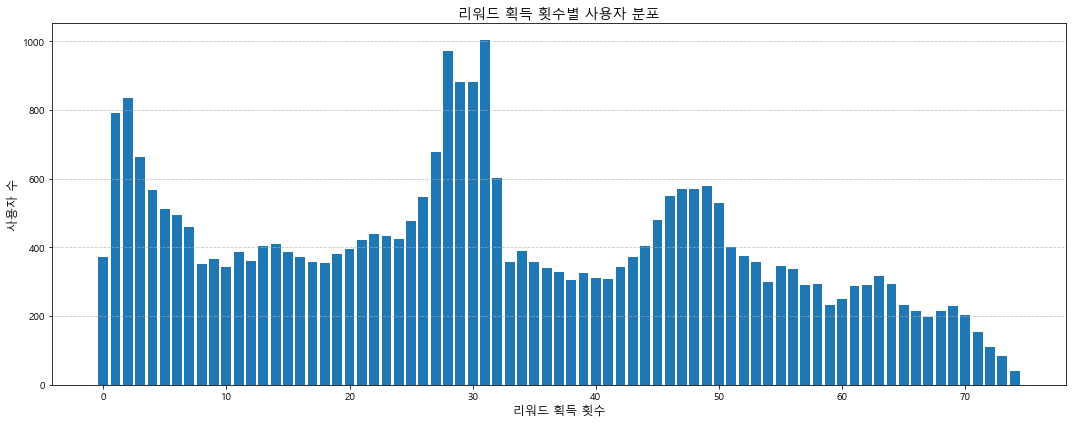

In [61]:
# 리워드 획득 횟수별 사용자 분포 분석
distribution_df = df.groupby("earn_reward_cnt")["user_id"].count().reset_index()
distribution_df = distribution_df.sort_values("earn_reward_cnt")

# 시각화 개선
plt.figure(figsize=(15, 6))
plt.bar(distribution_df["earn_reward_cnt"], distribution_df["user_id"])
plt.title("리워드 획득 횟수별 사용자 분포", fontsize=14)
plt.xlabel("리워드 획득 횟수", fontsize=12)
plt.ylabel("사용자 수", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# 기본 통계량 출력
print("리워드 획득 횟수 통계:")
print(f"평균: {df['earn_reward_cnt'].mean():.2f}")
print(f"중앙값: {df['earn_reward_cnt'].median():.2f}")
print(f"최소값: {df['earn_reward_cnt'].min():.2f}")
print(f"최대값: {df['earn_reward_cnt'].max():.2f}")

In [62]:
# 첫 번째 누적 금액 계산
df["first_cum_money"] = df.earn_reward + df.earn_exchange

# 5천 단위로 구간화
df["first_cum_money_bin"] = pd.cut(df["first_cum_money"], 
                                  bins=range(0, df["first_cum_money"].max().astype(int) + 5001, 5000),
                                  labels=[f"{i}-{i+4999}" for i in range(0, df["first_cum_money"].max().astype(int) + 5000, 5000)][:-1],
                                  right=False)

# 구간별 집계
df.groupby("first_cum_money_bin").agg({
    "user_id":'count',
    "pre_cash":'mean',
    "cur_shoji":'mean',
    "is_first_bankrupt":'sum',
    "is_churn":'sum',
    "second_cur_shoji":'count',
    # "earn_reward":'mean',
    "earn_exchange":'mean',
    "p_amt":'mean',
    "s_amt":'mean',
    "s_rto":'mean',
    }).reset_index()


,first_cum_money_bin,user_id,pre_cash,cur_shoji,is_first_bankrupt,is_churn,second_cur_shoji,earn_exchange,p_amt,s_amt,s_rto
0,0-4999,10962,9266.840358,311.766831,4436,4649,4146,703.246488,13378.378033,2547.710363,0.349309
1,5000-9999,5964,5367.981724,592.423374,2503,2655,1691,5186.854628,9853.522803,6485.030349,0.776367
2,10000-14999,5566,5766.796982,1221.333812,1999,2287,1228,10125.145167,13606.413942,11029.246856,0.871461
3,15000-19999,3317,2873.993368,2437.927043,878,1164,646,14726.357251,16587.636418,14431.1224,0.912752
4,20000-24999,2229,3511.782862,4216.988336,428,606,573,19432.10498,19335.302826,17166.509646,0.926267
5,25000-29999,1159,2621.157032,6539.287317,182,278,331,23898.70233,21264.693701,19398.880932,0.940552
6,30000-34999,606,3533.775578,8133.161716,74,129,214,28940.981848,22964.207921,21284.226073,0.948086
7,35000-39999,297,3122.606061,9791.333333,28,75,113,33921.59596,23770.303030,22453.902357,0.955825
8,40000-44999,186,5056.940860,8248.521505,28,34,89,35122.596774,24437.419355,22425.774194,0.939785
9,45000-49999,99,4466.575758,13166.393939,8,19,49,43585.767677,22433.232323,20515.808081,0.942020


In [63]:
df.columns

Index(['user_id', 'join_dt', 'p_date', 'cur_shoji', 'cur_cash', 'pre_shoji',
       'pre_cash', 'p_amt', 's_amt', 's_rto', 'earn_exchange',
       'earn_exchange_cnt', 'earn_reward', 'since_visit_dt', 'earn_reward_cnt',
       'rnk', 'is_churn', 'second_purchase_date', 'second_cur_shoji',
       'second_pre_shoji', 'second_pre_cash', 'second_p_amt', 'second_s_amt',
       'second_s_rto', 'second_earn_exchange', 'second_earn_exchange_cnt',
       'second_earn_reward', 'second_since_visit_dt', 'second_earn_reward_cnt',
       'between_earn_exchange', 'between_earn_exchange_cnt',
       'between_earn_reward', 'between_earn_reward_cnt',
       'days_between_purchases', 'pre_shoji_bin', 'pre_cash_bin',
       'is_first_bankrupt', 'pre_asset', 'second_pre_asset', 'first_cum_money',
       'first_cum_money_bin'],
      dtype='object')

### 재구매 통계

In [64]:
# 첫 번째 누적 금액 계산
df["first_cum_money"] = df.earn_reward + df.earn_exchange

# 5천 단위로 구간화
df["first_cum_money_bin"] = pd.cut(df["first_cum_money"], 
                                  bins=range(0, df["first_cum_money"].max().astype(int) + 5001, 5000),
                                  labels=[f"{i}-{i+4999}" for i in range(0, df["first_cum_money"].max().astype(int) + 5000, 5000)][:-1],
                                  right=False)

# 구간별 집계
df.groupby("first_cum_money_bin").agg({
    "user_id":'count',
    # "pre_cash":'mean',
    "cur_shoji":'mean',
    "is_first_bankrupt":'sum',
    "is_churn":'sum',
    # "earn_reward":'mean',
    "earn_exchange":'mean',
    "p_amt":'mean',
    "s_amt":'mean',
    "s_rto":'mean',
    "second_cur_shoji":'count',
    "earn_reward_cnt":'mean',
    "second_earn_reward":'mean',
    "second_earn_exchange":'mean',
    "second_earn_reward_cnt":'mean',
    "second_p_amt":'mean',
    "second_s_amt":'mean',
    "second_s_rto":'mean',
    }).reset_index()


,first_cum_money_bin,user_id,cur_shoji,is_first_bankrupt,is_churn,earn_exchange,p_amt,s_amt,s_rto,second_cur_shoji,earn_reward_cnt,second_earn_reward,second_earn_exchange,second_earn_reward_cnt,second_p_amt,second_s_amt,second_s_rto
0,0-4999,10962,311.766831,4436,4649,703.246488,13378.378033,2547.710363,0.349309,4146,22.652253,1689.42547,6438.411963,26.550169,14934.920405,6978.125422,0.582865
1,5000-9999,5964,592.423374,2503,2655,5186.854628,9853.522803,6485.030349,0.776367,1691,32.101945,2080.908338,8349.563572,28.170313,12145.251331,8944.321703,0.800514
2,10000-14999,5566,1221.333812,1999,2287,10125.145167,13606.413942,11029.246856,0.871461,1228,35.662954,1379.166938,5755.40798,19.934039,11638.021173,8389.149837,0.783160
3,15000-19999,3317,2437.927043,878,1164,14726.357251,16587.636418,14431.1224,0.912752,646,40.449804,1490.896285,2549.027864,21.346749,11441.764706,8144.399381,0.809226
4,20000-24999,2229,4216.988336,428,606,19432.10498,19335.302826,17166.509646,0.926267,573,42.740242,1553.77836,2256.404887,21.382199,12373.298429,9497.270506,0.824398
5,25000-29999,1159,6539.287317,182,278,23898.70233,21264.693701,19398.880932,0.940552,331,47.135462,1715.743202,1758.942598,21.912387,15362.567976,11896.848943,0.840272
6,30000-34999,606,8133.161716,74,129,28940.981848,22964.207921,21284.226073,0.948086,214,44.074257,1746.560748,1975.957944,22.78972,16616.355140,13110.079439,0.860374
7,35000-39999,297,9791.333333,28,75,33921.59596,23770.303030,22453.902357,0.955825,113,41.868687,1455.769912,2154.097345,21.743363,16668.761062,13542.053097,0.886991
8,40000-44999,186,8248.521505,28,34,35122.596774,24437.419355,22425.774194,0.939785,89,27.521505,11974.786517,4402.696629,23.247191,23402.247191,20110.662921,0.859551
9,45000-49999,99,13166.393939,8,19,43585.767677,22433.232323,20515.808081,0.942020,49,32.737374,3698.693878,3102.510204,22.979592,17593.877551,15074.510204,0.884898


In [65]:
df.columns

Index(['user_id', 'join_dt', 'p_date', 'cur_shoji', 'cur_cash', 'pre_shoji',
       'pre_cash', 'p_amt', 's_amt', 's_rto', 'earn_exchange',
       'earn_exchange_cnt', 'earn_reward', 'since_visit_dt', 'earn_reward_cnt',
       'rnk', 'is_churn', 'second_purchase_date', 'second_cur_shoji',
       'second_pre_shoji', 'second_pre_cash', 'second_p_amt', 'second_s_amt',
       'second_s_rto', 'second_earn_exchange', 'second_earn_exchange_cnt',
       'second_earn_reward', 'second_since_visit_dt', 'second_earn_reward_cnt',
       'between_earn_exchange', 'between_earn_exchange_cnt',
       'between_earn_reward', 'between_earn_reward_cnt',
       'days_between_purchases', 'pre_shoji_bin', 'pre_cash_bin',
       'is_first_bankrupt', 'pre_asset', 'second_pre_asset', 'first_cum_money',
       'first_cum_money_bin'],
      dtype='object')

In [66]:
# float 타입 오류 수정
# NaN 값을 제외하고 최대값 계산
max_value = df["second_p_amt"].dropna().max()
if pd.notna(max_value):
    max_int = int(max_value) + 5001
    # 레이블 개수는 구간 경계 개수보다 하나 적어야 함
    bins = list(range(0, max_int, 5000))
    labels = [f"{i}-{i+4999}" for i in range(0, max_int, 5000) if i < max_int - 5000]
    df["second_p_amt_bin"] = pd.cut(df["second_p_amt"], 
                                    bins=bins,
                                    labels=labels,
                                    right=False)
else:
    # 데이터가 없는 경우 빈 카테고리 생성
    df["second_p_amt_bin"] = pd.Categorical([])

df.groupby("second_p_amt_bin").agg({
    "user_id":'count',
    "second_pre_shoji":'mean',
    "second_pre_cash":'mean',
    "second_p_amt":'mean',
    "second_s_amt":'mean',
    "second_s_rto":'mean',
    "second_earn_reward":'mean',
    "second_earn_exchange":'mean',
    "second_earn_reward_cnt":'mean',
    }).reset_index()

,second_p_amt_bin,user_id,second_pre_shoji,second_pre_cash,second_p_amt,second_s_amt,second_s_rto,second_earn_reward,second_earn_exchange,second_earn_reward_cnt
0,0-4999,1541,5202.079818,2848.144737,4031.726152,3512.188838,0.872940,1586.045425,2215.791694,24.689812
1,5000-9999,2285,7791.717287,3684.197866,7905.045952,5919.422319,0.761133,1692.902407,4243.960613,25.225383
2,10000-14999,2570,9704.250584,4632.781618,12394.630350,8491.506615,0.685533,1704.624125,5788.266537,24.868482
3,15000-19999,1428,12836.185574,4193.262598,17392.296919,11949.851541,0.691064,1687.912465,8180.260504,24.880952
4,20000-24999,575,15012.050435,4345.664311,22241.408696,14079.283478,0.633130,1682.777391,10010.688696,24.817391
5,25000-29999,356,15909.061798,5063.095930,27690.028090,15447.581461,0.560478,2445.985955,9975.735955,27.789326
6,30000-34999,202,16031.851485,5274.955000,32659.900990,15749.564356,0.483020,3054.366337,8795.960396,24.361386
7,35000-39999,124,16184.483871,6895.764228,37791.532258,15839.072581,0.417903,3613.33871,8648.370968,22.459677
8,40000-44999,50,16156.22,8588.479167,42512.000000,16009.88,0.379600,4996.0,6558.28,17.36
9,45000-49999,32,17925.15625,7515.833333,47903.125000,18232.90625,0.376563,11490.25,5734.71875,11.4375


In [67]:
df.columns

Index(['user_id', 'join_dt', 'p_date', 'cur_shoji', 'cur_cash', 'pre_shoji',
       'pre_cash', 'p_amt', 's_amt', 's_rto', 'earn_exchange',
       'earn_exchange_cnt', 'earn_reward', 'since_visit_dt', 'earn_reward_cnt',
       'rnk', 'is_churn', 'second_purchase_date', 'second_cur_shoji',
       'second_pre_shoji', 'second_pre_cash', 'second_p_amt', 'second_s_amt',
       'second_s_rto', 'second_earn_exchange', 'second_earn_exchange_cnt',
       'second_earn_reward', 'second_since_visit_dt', 'second_earn_reward_cnt',
       'between_earn_exchange', 'between_earn_exchange_cnt',
       'between_earn_reward', 'between_earn_reward_cnt',
       'days_between_purchases', 'pre_shoji_bin', 'pre_cash_bin',
       'is_first_bankrupt', 'pre_asset', 'second_pre_asset', 'first_cum_money',
       'first_cum_money_bin', 'second_p_amt_bin'],
      dtype='object')

In [68]:
# 첫구매 시 쇼지 and 재산 5000미만 유저 필터링
tg = df.query("pre_shoji_bin == '0-4999' & pre_cash_bin == '0-4999'")[[
    'user_id','pre_shoji','pre_cash', 'cur_shoji','cur_cash',  'p_amt','s_amt','s_rto']]

tg['shoji_spent'] = tg['pre_shoji'] - tg['cur_shoji']
tg['cash_spent'] = tg['pre_cash'] - tg['cur_cash']


tg.user_id.nunique()


4675

## 수익성 분석

### 첫구매 시 재산 적었던 유저 or 전체유저 필터링하여 분석 
- 첫 구매시 쇼지 <= 5000 and 캐시가 <= 5000인 유저 필터링
- 해당 타겟의 전체 구매 평균 통계값 도출하여 분석

In [69]:
# 리스트의 요소들을 쉼표로 구분된 문자열로 변환
user_ids_str = ", ".join([f"'{user_id}'" for user_id in tg.user_id.tolist()])

# 저재산 유저
tg_query_1 = """
    SELECT 
        user_id, register_dt, pre_shoji, pre_cash, current_shoji, current_cash, purchase, earn_total, spend_total, 
        spend_use, earn_reward,earn_cash_direct_exchange, earn_exchange, earn_recall
    FROM dm.agg_user_cash_daily
    WHERE 1=1 
    and user_id IN ({})
        and purchase is not null
        and register_dt > "2024-12-31"
""".format(user_ids_str)
# 전체 유저
tg_query_2 = """
    SELECT 
        user_id, register_dt, pre_shoji, pre_cash, current_shoji, current_cash, purchase, earn_total, spend_total, 
        spend_use, earn_reward,earn_cash_direct_exchange, earn_exchange, earn_recall
    FROM dm.agg_user_cash_daily
    WHERE 1=1 
        and purchase is not null
        and register_dt > "2024-12-31"
""".format(user_ids_str)

tg_df = bq.query(tg_query_2).to_dataframe()

tg_df.head()

c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


,user_id,register_dt,pre_shoji,pre_cash,current_shoji,current_cash,purchase,earn_total,spend_total,spend_use,earn_reward,earn_cash_direct_exchange,earn_exchange,earn_recall
0,dc8ec242-e322-4b33-bfdc-efb99575a0fd,2025-03-31,6360,155.0,1,55.0,6500.0,141,6500,6500,41,0,100,0
1,91158b82-f458-4e38-85b1-773ddbd0a379,2025-04-07,11548,96.0,875,96.0,10400.0,36,10709,10400,36,0,0,0
2,9fedbebb-2e7f-42ca-9d50-4211b1ab7785,2025-03-29,28276,69.0,0,69.0,56900.0,347,28623,28623,347,0,0,0
3,b0fdd241-e3b2-45a5-b9ab-5822bfabdc8c,2025-02-16,10314,164.0,0,64.0,14200.0,100,10414,10414,0,0,100,0
4,262356e1-0a7e-4b4a-969a-9fa5300135c9,2025-04-03,26532,49.0,3636,49.0,22900.0,22,22918,22900,22,0,0,0


In [70]:
tg_df.iloc[:,2:] = tg_df.iloc[:,2:].astype(float)
tg_df['earn_exchange'] = tg_df['earn_exchange'] + tg_df['earn_cash_direct_exchange']
tg_df['s_rto'] = round(
    (tg_df['spend_total']  / tg_df['purchase']).where(
        tg_df['earn_recall'] > tg_df['spend_use'],
        (tg_df['spend_use'] - tg_df['earn_recall']) / tg_df['purchase']
    ), 2)
# cash_rto 계산
# cash_rto 계산 - inf 처리 및 최대값 1 제한
tg_df['cash_rto'] = (tg_df['earn_exchange'] / tg_df['spend_total']).where(
    tg_df['earn_recall'] > tg_df['spend_use'],
    tg_df['earn_exchange'] / (tg_df['spend_use'] - tg_df['earn_recall'])
).clip(upper=1.0).fillna(1.0).round(2)
tg_df.groupby('user_id').agg({
    'purchase':'count',
    'earn_total':'sum',
    'spend_use':'sum',
    'earn_reward':'sum',
    'earn_exchange':'sum',
    's_rto':'mean',
    'cash_rto':'mean',
    }).reset_index().head()

tg_df['cash_direct_rto'] = (tg_df['earn_cash_direct_exchange'] / tg_df['spend_total']).clip(upper=1.0)

tg_df[(tg_df['s_rto'] <= 0.06) & (tg_df['s_rto'] >= 0.04)].cash_direct_rto.mean()
tg_df['s_rto'] = tg_df['s_rto'].clip(lower=0.0)
tg_df['s_rto'] = tg_df['s_rto'].clip(upper=1)

<ipython-input-70-42021dd14ca1>:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  tg_df.iloc[:,2:] = tg_df.iloc[:,2:].astype(float)


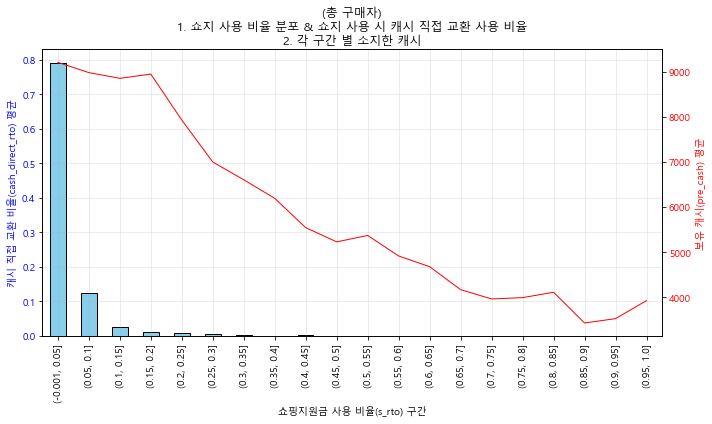

In [72]:
# s_rto를 50개 구간으로 나누고 각 구간별 cash_direct_rto 평균과 pre_cash 평균 계산
fig, ax1 = plt.subplots(figsize=(10, 6))

# s_rto를 50개 구간으로 나누기
s_rto_bins = pd.cut(tg_df.s_rto, bins=20)

# 각 구간별 cash_direct_rto 평균 계산
s_rto_cash_direct_avg = tg_df.groupby(s_rto_bins)['cash_direct_rto'].mean()

# 각 구간별 pre_cash 평균 계산
s_rto_pre_cash_avg = tg_df.groupby(s_rto_bins)['pre_cash'].mean()

# 첫 번째 y축에 cash_direct_rto 평균 그래프 그리기
s_rto_cash_direct_avg.plot(kind='bar', ax=ax1, color='skyblue', edgecolor='black')
ax1.set_xlabel('쇼핑지원금 사용 비율(s_rto) 구간')
ax1.set_ylabel('캐시 직접 교환 비율(cash_direct_rto) 평균', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# 두 번째 y축 생성하여 pre_cash 평균 라인 그래프 추가
ax2 = ax1.twinx()
s_rto_pre_cash_avg.plot(kind='line', ax=ax2, color='red', linestyle='-', linewidth=1)
ax2.set_ylabel('보유 캐시(pre_cash) 평균', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('(총 구매자)\n'
          '1. 쇼지 사용 비율 분포 & 쇼지 사용 시 캐시 직접 교환 사용 비율\n'
          '2. 각 구간 별 소지한 캐시')
# plt.title('(첫구매 시 쇼지+캐시 5000미만)\n'
#           '1. 쇼지 사용 비율 분포 & 쇼지 사용 시 캐시 직접 교환 사용 비율\n'
#           '2. 각 구간 별 소지한 캐시')
# plt.text(0.5, 0.95, '5% 사용 구간에 캐시 직접 교환 비율이 높은 경향', 
#          ha='center', va='center',style='italic', transform=plt.gca().transAxes, fontsize=12)
plt.xticks(rotation=90)
ax1.grid(True, alpha=0.3)
plt.tight_layout()


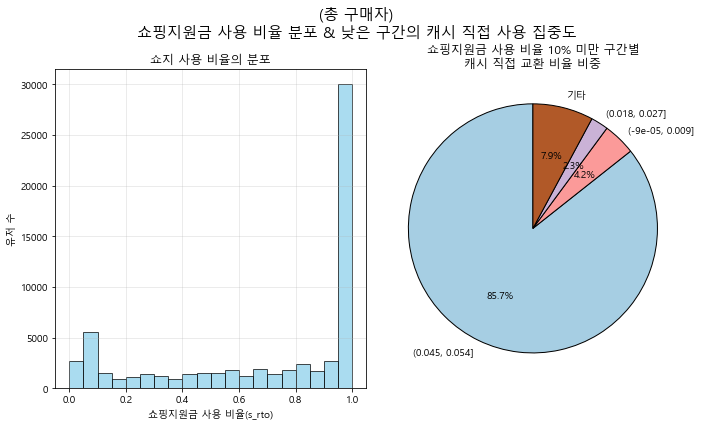

In [73]:
# s_rto와 cash_direct_rto 관계 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

# s_rto 히스토그램
ax1.hist(tg_df.s_rto, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
ax1.set_xlabel('쇼핑지원금 사용 비율(s_rto)')
ax1.set_ylabel('유저 수')
ax1.set_title('쇼지 사용 비율의 분포')
ax1.grid(True, alpha=0.3)

# s_rto가 10% 미만인 구간에서의 cash_direct_rto 분석
low_s_rto_users = tg_df[tg_df.s_rto < 0.1]
s_rto_bins_low = pd.cut(low_s_rto_users.s_rto, bins=10)
cash_direct_by_s_rto = low_s_rto_users.groupby(s_rto_bins_low)['cash_direct_rto'].mean()

# 전체 구간 대비 각 구간의 cash_direct_rto 비중을 파이 차트로 표현
total_cash_direct = low_s_rto_users['cash_direct_rto'].sum()
cash_direct_proportion = low_s_rto_users.groupby(s_rto_bins_low)['cash_direct_rto'].sum() / total_cash_direct

# 파이 차트 그리기
# 상위 3개 미만 기타로 통합
sorted_proportions = cash_direct_proportion.sort_values(ascending=False)
top_3 = sorted_proportions.iloc[:3]
others = pd.Series({'기타': sorted_proportions.iloc[3:].sum()})
combined_proportions = pd.concat([top_3, others])

combined_proportions.plot(kind='pie', ax=ax2, autopct='%1.1f%%', startangle=90, 
                         colors=plt.cm.Paired(np.linspace(0, 1, len(combined_proportions))),
                         wedgeprops={'edgecolor': 'black', 'linewidth': 1})
ax2.set_ylabel('')  # y 레이블 제거
ax2.set_title('쇼핑지원금 사용 비율 10% 미만 구간별\n캐시 직접 교환 비율 비중')

plt.suptitle('(총 구매자)\n'
             '쇼핑지원금 사용 비율 분포 & 낮은 구간의 캐시 직접 사용 집중도', fontsize=15)
# plt.suptitle('(첫구매 시 쇼지+캐시 5000미만)\n'
#              '쇼핑지원금 사용 비율 분포 & 낮은 구간의 캐시 직접 사용 집중도', fontsize=15)
plt.tight_layout()

In [74]:
# 전체 
pd.cut(tg_df.s_rto, bins=20).value_counts()

(0.95, 1.0]       30051
(-0.001, 0.05]     7456
(0.9, 0.95]        2246
(0.85, 0.9]        2109
(0.8, 0.85]        2056
(0.75, 0.8]        1804
(0.7, 0.75]        1685
(0.65, 0.7]        1616
(0.45, 0.5]        1565
(0.55, 0.6]        1515
(0.6, 0.65]        1515
(0.4, 0.45]        1400
(0.5, 0.55]        1357
(0.3, 0.35]        1226
(0.1, 0.15]        1191
(0.35, 0.4]        1189
(0.25, 0.3]        1178
(0.2, 0.25]        1142
(0.15, 0.2]        1095
(0.05, 0.1]        1072
Name: s_rto, dtype: int64

소비 비율 구간별 유저 수:
(-0.002, 0.1]    46353
(0.1, 0.2]        1876
(0.2, 0.3]        1336
(0.3, 0.4]         867
(0.4, 0.5]         778
(0.5, 0.6]         763
(0.6, 0.7]         792
(0.7, 0.8]        1039
(0.8, 0.9]        1025
(0.9, 1.0]        9639
Name: cash_rto, dtype: int64


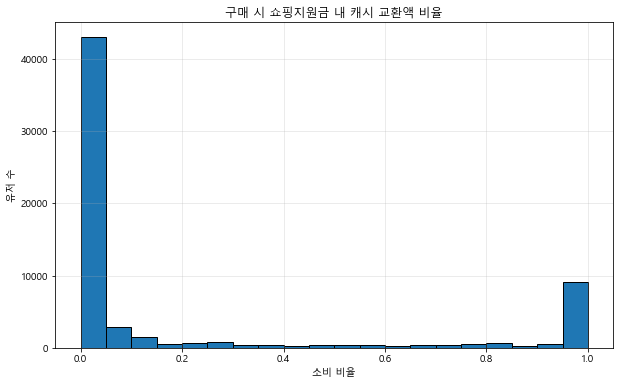

In [75]:
# s_rto 비율에 대한 히스토그램 생성
plt.figure(figsize=(10, 6))
plt.hist(tg_df.cash_rto, bins=20, edgecolor='black')
plt.title('소비 비율(s_rto) 분포')
plt.xlabel('소비 비율')
plt.ylabel('유저 수')
plt.title('구매 시 쇼핑지원금 내 캐시 교환액 비율')
plt.grid(True, alpha=0.3)

# 각 비율 구간별 유저 수 계산
cash_rto_counts = tg_df.cash_rto.value_counts(bins=10).sort_index()
print("소비 비율 구간별 유저 수:")
print(cash_rto_counts)

캐시 교환 비율 구간별 유저 수:
(-0.002, 0.1]    46353
(0.1, 0.2]        1876
(0.2, 0.3]        1336
(0.3, 0.4]         867
(0.4, 0.5]         778
(0.5, 0.6]         763
(0.6, 0.7]         792
(0.7, 0.8]        1039
(0.8, 0.9]        1025
(0.9, 1.0]        9639
Name: cash_rto, dtype: int64


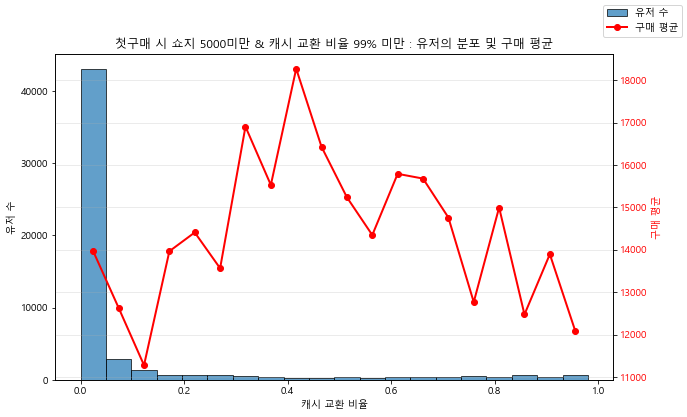

In [76]:
# cash_rto 비율과 purchase 평균을 히스토그램으로 표현
fig, ax1 = plt.figure(figsize=(10, 6)), plt.gca()

# cash_rto 히스토그램
n, bins, patches = ax1.hist(tg_df.query("cash_rto < 0.99").cash_rto, bins=20, edgecolor='black', alpha=0.7, label='유저 수')

# 두 번째 y축 생성
ax2 = ax1.twinx()

# 각 구간별 purchase 평균 계산
purchase_means = []
for i in range(len(bins)-1):
    mask = (tg_df.cash_rto >= bins[i]) & (tg_df.cash_rto < bins[i+1]) & (tg_df.cash_rto < 0.99)
    purchase_means.append(tg_df[mask].purchase.mean())

# purchase 평균 선 그래프 추가
bin_centers = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
ax2.plot(bin_centers, purchase_means, color='red', marker='o', linestyle='-', linewidth=2, label='구매 평균')

# 그래프 설정
ax1.set_xlabel('캐시 교환 비율')
ax1.set_ylabel('유저 수')
ax2.set_ylabel('구매 평균', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('첫구매 시 쇼지 5000미만 & 캐시 교환 비율 99% 미만 : 유저의 분포 및 구매 평균')
fig.legend(loc='upper right')
plt.grid(True, alpha=0.3)

# 각 비율 구간별 유저 수 계산
cash_rto_counts = tg_df.cash_rto.value_counts(bins=10).sort_index()
print("캐시 교환 비율 구간별 유저 수:")
print(cash_rto_counts)

캐시 교환 비율 구간별 유저 수:
(-0.002, 0.1]    46353
(0.1, 0.2]        1876
(0.2, 0.3]        1336
(0.3, 0.4]         867
(0.4, 0.5]         778
(0.5, 0.6]         763
(0.6, 0.7]         792
(0.7, 0.8]        1039
(0.8, 0.9]        1025
(0.9, 1.0]        9639
Name: cash_rto, dtype: int64


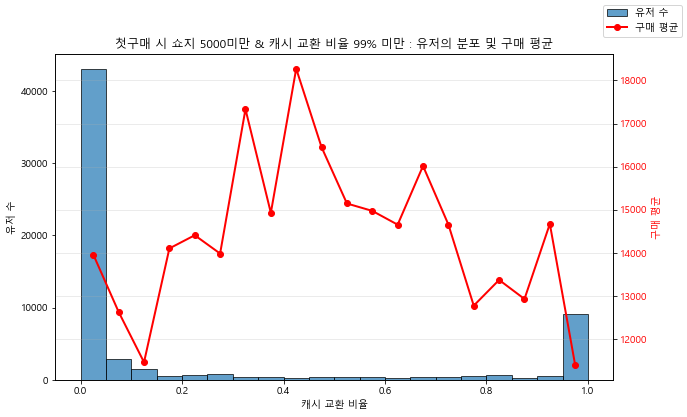

In [77]:
# cash_rto 비율과 purchase 평균을 히스토그램으로 표현
fig, ax1 = plt.figure(figsize=(10, 6)), plt.gca()

# cash_rto 히스토그램
n, bins, patches = ax1.hist(tg_df.cash_rto, bins=20, edgecolor='black', alpha=0.7, label='유저 수')

# 두 번째 y축 생성
ax2 = ax1.twinx()

# 각 구간별 purchase 평균 계산
purchase_means = []
for i in range(len(bins)-1):
    mask = (tg_df.cash_rto >= bins[i]) & (tg_df.cash_rto < bins[i+1])
    purchase_means.append(tg_df[mask].purchase.mean())

# purchase 평균 선 그래프 추가
bin_centers = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
ax2.plot(bin_centers, purchase_means, color='red', marker='o', linestyle='-', linewidth=2, label='구매 평균')

# 그래프 설정
ax1.set_xlabel('캐시 교환 비율')
ax1.set_ylabel('유저 수')
ax2.set_ylabel('구매 평균', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('첫구매 시 쇼지 5000미만 & 캐시 교환 비율 99% 미만 : 유저의 분포 및 구매 평균')
fig.legend(loc='upper right')
plt.grid(True, alpha=0.3)

# 각 비율 구간별 유저 수 계산
cash_rto_counts = tg_df.cash_rto.value_counts(bins=10).sort_index()
print("캐시 교환 비율 구간별 유저 수:")
print(cash_rto_counts)

쇼지사용 비율 구간별 유저 수:
(-0.002, 0.1]     8528
(0.1, 0.2]        2286
(0.2, 0.3]        2320
(0.3, 0.4]        2415
(0.4, 0.5]        2965
(0.5, 0.6]        2872
(0.6, 0.7]        3131
(0.7, 0.8]        3489
(0.8, 0.9]        4165
(0.9, 1.0]       32297
Name: s_rto, dtype: int64


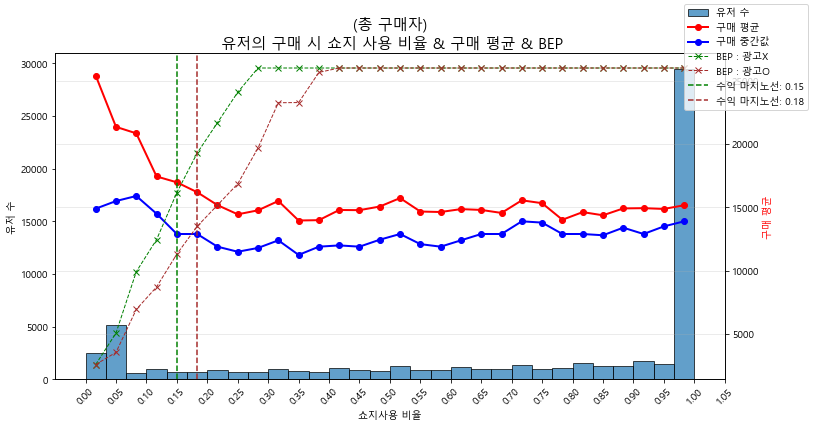

In [78]:
# s_rto 비율과 purchase 평균을 히스토그램으로 표현
fig, ax1 = plt.figure(figsize=(12, 6)), plt.gca()

# s_rto 히스토그램
n, bins, patches = ax1.hist(tg_df.s_rto, bins=30, edgecolor='black', alpha=0.7, label='유저 수')
plt.xticks(rotation=45)
ax1.set_xticks(np.arange(0, 1.1, 0.05))  # x축 눈금을 0부터 1까지 0.05 간격으로 설정

# 두 번째 y축 생성
ax2 = ax1.twinx()

# 각 구간별 purchase 평균 계산
purchase_means = []
for i in range(len(bins)-1):
    mask = (tg_df.s_rto >= bins[i]) & (tg_df.s_rto < bins[i+1])
    purchase_means.append(tg_df[mask].purchase.mean())
purchase_medians = []
for i in range(len(bins)-1):
    mask = (tg_df.s_rto >= bins[i]) & (tg_df.s_rto < bins[i+1])
    purchase_medians.append(tg_df[mask].purchase.median())

# purchase 평균 선 그래프 추가
bin_centers = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
ax2.plot(bin_centers, purchase_means, color='red', marker='o', linestyle='-', linewidth=2, label='구매 평균')
ax2.plot(bin_centers, purchase_medians, color='blue', marker='o', linestyle='-', linewidth=2, label='구매 중간값')

### 쇼지 사용액 당 bep 그래프 추가
import numpy as np
shoji_purchase_means = np.multiply(purchase_means, bins[:len(purchase_means)])
shoji_price_cut = np.multiply(shoji_purchase_means, 7.143)
shoji_price_cut = np.minimum(np.maximum(shoji_price_cut, 2600), 26000)
# 광고 O
shoji_purchase_means_ad = np.multiply(purchase_means, bins[:len(purchase_means)])
shoji_price_cut_ad = np.multiply(shoji_purchase_means_ad, 5.0)
shoji_price_cut_ad = np.minimum(np.maximum(shoji_price_cut_ad, 2600), 26000)
# ax2 축에 쇼지 사용액 당 bep 그래프 추가
ax2.plot(bin_centers, shoji_price_cut, color='green', marker='x', linestyle='--', linewidth=1, label='BEP : 광고X')
ax2.plot(bin_centers, shoji_price_cut_ad, color='brown', marker='x', linestyle='--', linewidth=1, label='BEP : 광고O')

# purchase_means < shoji_price_cut 조건을 만족하는 최댓값 찾기
valid_indices = [i for i in range(len(purchase_means)) if purchase_means[i] > shoji_price_cut[i]]
if valid_indices:
    max_index = max(valid_indices)
    # 해당 위치에 수직선 추가
    ax2.axvline(x=bin_centers[max_index], color='green', linestyle='--', linewidth=1.5, 
                label=f'수익 마지노선: {bin_centers[max_index]:.2f}')
valid_indices_ad = [i for i in range(len(purchase_means)) if purchase_means[i] > shoji_price_cut_ad[i]]
if valid_indices_ad:
    max_index = max(valid_indices_ad)
    # 해당 위치에 수직선 추가
    ax2.axvline(x=bin_centers[max_index], color='brown', linestyle='--', linewidth=1.5, 
                label=f'수익 마지노선: {bin_centers[max_index]:.2f}')

# 그래프 설정
ax1.set_xlabel('쇼지사용 비율')
ax1.set_ylabel('유저 수')
ax2.set_ylabel('구매 평균', color='red')
ax2.tick_params(axis='y', labelcolor='black')

# plt.title('(첫 구매 시 쇼지+캐시 5000미만)\n'
        #   ' 유저의 구매 시 쇼지 사용 비율 & 구매 평균 & BEP', fontsize=15)
plt.title('(총 구매자)\n'
          ' 유저의 구매 시 쇼지 사용 비율 & 구매 평균 & BEP', fontsize=15)
fig.legend(loc='upper right')
plt.grid(True, alpha=0.3)

# 각 비율 구간별 유저 수 계산
s_rto_counts = tg_df.s_rto.value_counts(bins=10).sort_index()
print("쇼지사용 비율 구간별 유저 수:")
print(s_rto_counts) 

In [106]:
df.

(array([    0.        ,   711.85364132,  1389.52128248,  1744.2168926 ,
         2263.57642726,  2699.82951654,  3035.89834254,  3372.32248521,
         3938.44897959,  4651.76677316,  4654.79547433,  5130.74257908,
         5917.90386428,  6405.65455213,  7031.63086714,  7867.7773344 ,
         7825.52019002,  8293.22036418,  8918.77910959,  9372.67906336,
         9707.85589367, 10890.96296296, 11243.33333333, 10751.72051996,
        11701.94079794, 11980.19040167, 12929.86850857, 13444.92521739,
        13885.99323867, 14661.96822222]),
 array([ 2600.        ,  5084.77055996,  9925.35052073, 12458.94126382,
        16168.72641989, 19284.88223664, 21685.42186077, 24088.49951183,
        26000.        , 26000.        , 26000.        , 26000.        ,
        26000.        , 26000.        , 26000.        , 26000.        ,
        26000.        , 26000.        , 26000.        , 26000.        ,
        26000.        , 26000.        , 26000.        , 26000.        ,
        26000.        

In [ ]:
[i for i in range(len(purchase_means)) if purchase_means[i] > shoji_price_cut[i]]

#### 수익 타겟 프로파일링

In [101]:
# s_rto가 0.20 이하인 유저 추출
low_s_rto_users = tg_df.query("s_rto <= 0.20")
# 해당 유저들의 ID 리스트 생성
rtg = low_s_rto_users.user_id.tolist()
# rtg 리스트를 사용하여 원본 데이터프레임 필터링
filtered_df = df[df.user_id.isin(rtg)]
# 필터링된 결과 확인
filtered_df.groupby("earn_reward_cnt").agg({
    "user_id":'count',
    "pre_shoji":'mean',
    "pre_cash":"mean",
    "is_first_bankrupt":'sum',
    "is_churn":'sum',
    "second_cur_shoji":'count',
    "earn_reward":'mean',
    "earn_exchange":'mean',
    "p_amt":'mean',
    "s_amt":'mean',
    "s_rto":'mean',
    'second_pre_shoji':'mean',
    'second_pre_cash':'mean',
    'between_earn_reward_cnt':'mean',
    'between_earn_reward':'mean',
    'pre_asset':'mean',
    'second_pre_asset':'mean'
    }).reset_index()

,earn_reward_cnt,user_id,pre_shoji,pre_cash,is_first_bankrupt,is_churn,second_cur_shoji,earn_reward,earn_exchange,p_amt,s_amt,s_rto,second_pre_shoji,second_pre_cash,between_earn_reward_cnt,between_earn_reward,pre_asset,second_pre_asset
0,0.0,118,512.169492,2959.830508,113,107,17,0.0,547.322034,19496.610169,853.898305,0.057797,2016.176471,4882.937500,6.2,205.3,3472.0,7016.6875
1,1.0,270,1542.377778,4570.151852,77,214,78,399.059259,2115.433333,20574.962963,1641.862963,0.090704,3176.538462,5808.253333,9.983333,579.5,6112.52963,9025.133333
2,2.0,251,1569.131474,8138.187251,39,156,113,288.043825,2185.462151,19270.239044,1731.011952,0.085618,3037.902655,8894.571429,17.112245,982.561224,9707.318725,11958.151786
3,3.0,301,1431.495017,9232.661130,30,174,140,274.418605,2025.215947,19838.006645,1800.458472,0.100532,3164.75,8879.620438,18.775,1506.591667,10664.156146,12037.021898
4,4.0,234,1019.747863,10874.991453,29,126,106,231.183761,1290.457265,22142.136752,1634.025641,0.083504,4856.141509,9493.320755,24.336735,1750.836735,11894.739316,14349.462264
5,5.0,233,1847.484979,9348.094421,34,129,104,544.2103,2204.339056,19485.922747,1767.103004,0.095966,4199.182692,8701.271845,20.776596,1204.595745,11195.579399,12935.009709
6,6.0,214,1136.948598,11808.574766,28,104,115,724.439252,874.761682,21614.112150,1617.920561,0.073925,4483.356522,10804.736842,26.686275,1958.588235,12945.523364,14888.508772
7,7.0,203,1037.576355,10255.246305,42,86,98,504.743842,827.0,18777.832512,1205.571429,0.069852,4498.653061,9696.135417,24.511364,1406.738636,11292.82266,13902.458333
8,8.0,147,1396.619048,10896.013605,17,73,74,830.068027,717.877551,21717.891156,1478.965986,0.081905,4626.135135,10328.356164,22.25,1223.125,12292.632653,15016.876712
9,9.0,158,1231.101266,10943.000000,27,65,74,745.082278,674.797468,23253.417722,1552.278481,0.085570,5794.040541,7942.123288,21.720588,1123.382353,12174.101266,13809.821918


In [102]:
filtered_df.groupby(['pre_shoji_bin','pre_cash_bin']).agg({
    'join_dt': ['median','mean','min','max'],
    'user_id': 'count',
    'is_first_bankrupt': 'sum',
    'is_churn': 'sum',
    "second_cur_shoji" :'count',
    'pre_cash': 'mean',
    'pre_shoji': 'mean',
    'p_amt': 'mean',
    's_amt': 'mean',
    's_rto': 'mean',
    'earn_exchange': 'mean',
    'earn_reward': 'mean',
    'earn_reward_cnt': ['median','mean','max'],
    }).reset_index()

pre_shoji_bin pre_cash_bin join_dt                         user_id  \
                               median        mean   min   max   count   
0         0-4999       0-4999   559.0  545.697955   110   841    1907   
1         0-4999    5000-9999   574.0  569.946833   151   824    1279   
2         0-4999  10000-14999   581.0  583.750513   190   839     974   
3         0-4999  15000-19999   582.5  588.486034   270   819     716   
4         0-4999  20000-24999   597.0  597.558753   293   822     417   
5         0-4999  25000-29999   594.5  604.316038   311   807     212   
6         0-4999       30000+   593.0  593.116883   259   812     154   
7      5000-9999       0-4999   580.0  559.594406   109   803     143   
8      5000-9999    5000-9999   623.5  612.305556   391   774      36   
9      5000-9999  10000-14999   539.5   563.28125   366   807      32   
10     5000-9999  15000-19999   560.5  558.888889   382   740      18   
11     5000-9999  20000-24999   561.0  601.058824   441   801      17   
12     5000-9999  25000-29999   640.0  614.428571   413   730       7   
13     5000-9999       30000+   572.0       577.4   453   686      10   
14   10000-14999       0-4999   592.0   577.43038   202   841      79   
15   10000-14999    5000-9999   599.0  598.857143   282   812      21   
16   10000-14999  10000-14999   620.0  619.461538   488   780      13   
17   10000-14999  15000-19999   512.0  506.090909   404   596      11   
18   10000-14999  20000-24999   622.0       628.0   601   661       3   
19   10000-14999  25000-29999   518.0       527.0   470   593       3   
20   10000-14999       30000+    <NA>        <NA>  <NA>  <NA>       0   
21   15000-19999       0-4999   584.0  574.117647   331   804      68   
22   15000-19999    5000-9999   443.0       443.0   443   443       1   
23   15000-19999  10000-14999    <NA>        <NA>  <NA>  <NA>       0   
24   15000-19999  15000-19999   737.0       684.8   537   807       5   
25   15000-19999  20000-24999   573.5      601.25   506   752       4   
26   15000-19999  25000-29999    <NA>        <NA>  <NA>  <NA>       0   
27   15000-19999       30000+    <NA>        <NA>  <NA>  <NA>       0   
28   20000-24999       0-4999   622.0  598.061224   294   800      49   
29   20000-24999    5000-9999   685.0  635.166667   419   749       6   
30   20000-24999  10000-14999   674.0  707.333333   635   813       3   
31   20000-24999  15000-19999   666.0       666.0   537   795       2   
32   20000-24999  20000-24999    <NA>        <NA>  <NA>  <NA>       0   
33   20000-24999  25000-29999    <NA>        <NA>  <NA>  <NA>       0   
34   20000-24999       30000+   611.0       611.0   611   611       1   
35   25000-29999       0-4999   598.0  588.814815   301   811      27   
36   25000-29999    5000-9999   683.0       683.0   683   683       1   
37   25000-29999  10000-14999    <NA>        <NA>  <NA>  <NA>       0   
38   25000-29999  15000-19999   577.0       577.0   577   577       1   
39   25000-29999  20000-24999    <NA>        <NA>  <NA>  <NA>       0   
40   25000-29999  25000-29999    <NA>        <NA>  <NA>  <NA>       0   
41   25000-29999       30000+    <NA>        <NA>  <NA>  <NA>       0   
42        30000+       0-4999   632.0   603.78125   156   784      32   
43        30000+    5000-9999   614.0  619.857143   537   726       7   
44        30000+  10000-14999    <NA>        <NA>  <NA>  <NA>       0   
45        30000+  15000-19999   686.0       686.0   686   686       1   
46        30000+  20000-24999   799.0       799.0   799   799       1   
47        30000+  25000-29999    <NA>        <NA>  <NA>  <NA>       0   
48        30000+       30000+    <NA>        <NA>  <NA>  <NA>       0   

   is_first_bankrupt is_churn second_cur_shoji      pre_cash     pre_shoji  \
                 sum      sum            count          mean          mean   
0                611     1018              480   2122.758259    779.472994   
1                345      535              52

In [116]:
filtered_df.columns

Index(['user_id', 'join_dt', 'p_date', 'cur_shoji', 'cur_cash', 'pre_shoji',
       'pre_cash', 'p_amt', 's_amt', 's_rto', 'earn_exchange',
       'earn_exchange_cnt', 'earn_reward', 'since_visit_dt', 'earn_reward_cnt',
       'rnk', 'is_churn', 'second_purchase_date', 'second_cur_shoji',
       'second_pre_shoji', 'second_pre_cash', 'second_p_amt', 'second_s_amt',
       'second_s_rto', 'second_earn_exchange', 'second_earn_exchange_cnt',
       'second_earn_reward', 'second_since_visit_dt', 'second_earn_reward_cnt',
       'between_earn_exchange', 'between_earn_exchange_cnt',
       'between_earn_reward', 'between_earn_reward_cnt',
       'days_between_purchases', 'pre_shoji_bin', 'pre_cash_bin',
       'is_first_bankrupt', 'pre_asset', 'second_pre_asset', 'first_cum_money',
       'first_cum_money_bin', 'second_p_amt_bin'],
      dtype='object')

In [118]:
filtered_df["pre_asset_bin"] = pd.cut(filtered_df["pre_asset"], 
                                  bins=range(0, filtered_df["pre_asset"].max().astype(int) + 5001, 5000),
                                  labels=[f"{i}-{i+4999}" for i in range(0, filtered_df["pre_asset"].max().astype(int) + 5000, 5000)][:-1],
                                  right=False)
filtered_df.groupby(['pre_asset_bin']).agg({
    "user_id":'count',
    "pre_shoji":'mean',
    "pre_cash":"mean",
    "is_first_bankrupt":'sum',
    "is_churn":'sum',
    "second_cur_shoji":'count',
    "earn_reward":'mean',
    "earn_exchange":'mean',
    "p_amt":'mean',
    "s_amt":'mean',
    "s_rto":'mean',
    'second_pre_shoji':'mean',
    'second_pre_cash':'mean',
    'between_earn_reward_cnt':'mean',
    'between_earn_reward':'mean',
    'second_pre_asset':'mean',
    "second_s_rto":'mean'
    }).reset_index()

<ipython-input-118-ab2232b794be>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["pre_asset_bin"] = pd.cut(filtered_df["pre_asset"],


,pre_asset_bin,user_id,pre_shoji,pre_cash,is_first_bankrupt,is_churn,second_cur_shoji,earn_reward,earn_exchange,p_amt,s_amt,s_rto,second_pre_shoji,second_pre_cash,between_earn_reward_cnt,between_earn_reward,second_pre_asset,second_s_rto
0,0-4999,1653,594.398064,1835.026013,517,939,369,465.406534,498.794918,17080.532365,860.346642,0.063091,1732.246612,1355.440233,19.619195,961.721362,2869.635569,0.176883
1,5000-9999,1413,1457.698514,5875.726822,387,599,615,958.021231,815.907997,17900.601557,1550.283793,0.119618,2915.515447,3506.402936,22.041071,1167.266071,6428.057096,0.294504
2,10000-14999,1090,2301.085321,10186.799083,314,374,557,1296.16422,1467.830275,18276.146789,2066.712844,0.148908,4621.183124,6264.287523,20.482828,1195.777778,10845.732369,0.367720
3,15000-19999,900,2891.166667,14463.452222,245,262,517,1471.942222,1935.942222,20934.088889,2374.938889,0.145067,6494.578337,9053.362573,22.695931,1329.937901,15515.362573,0.405048
4,20000-24999,592,3817.435811,18548.942568,136,144,378,1679.885135,2778.010135,21592.415541,2774.888514,0.162753,8379.320106,11870.329787,24.10119,1483.708333,20161.965426,0.442857
5,25000-29999,313,4790.543131,22501.290735,57,78,211,1808.13738,3883.073482,24743.961661,3208.661342,0.159393,10789.729858,13854.739336,22.213198,1520.588832,24644.469194,0.484834
6,30000-34999,161,5622.118012,26639.850932,30,29,129,1802.565217,5639.906832,26329.689441,3508.124224,0.194720,13079.286822,16806.929688,23.322581,1956.193548,29699.789062,0.484109
7,35000-39999,74,7355.162162,29863.270270,14,13,59,1848.310811,7432.567568,27713.513514,4716.472973,0.247568,12613.322034,19348.050847,20.730769,1550.442308,31961.372881,0.422373
8,40000-44999,36,13772.861111,27912.888889,7,4,28,4628.944444,14731.083333,35516.666667,8900.083333,0.398889,17065.107143,17287.370370,27.8,3997.48,34969.074074,0.540000
9,45000-49999,7,22886.0,23725.857143,1,3,7,1561.714286,32293.428571,43900.000000,12480.285714,0.291429,15802.142857,18713.428571,17.0,1420.714286,34515.571429,0.414286


In [91]:
# s_rto가 0.20 이하인 유저 추출
low_s_rto_users = tg_df.query("s_rto <= 0.20")

# s_rto가 낮은 유저들의 특성 분석
low_s_rto_users.groupby('pre_cash_bin').agg({
    'user_id': 'count',
    'pre_shoji': 'mean',
    'pre_cash': 'mean',
    'p_amt': 'mean',
    's_amt': 'mean',
    's_rto': 'mean',
    'earn_exchange': 'mean',
    'earn_reward': 'mean',
    'is_first_bankrupt': 'sum'
}).reset_index()

KeyError: 'pre_cash_bin'

### 12/31 이래로, 총 재산이 별로 없을떄 유저들의 구매 패턴 

In [ ]:
## 구매당시 5000원 미만 재산 유저들들
tg_query = """
    with raw as
    (select user_id, register_dt, current_shoji, current_cash, purchase, earn_total, spend_total, spend_use, earn_reward,earn_cash_direct_exchange, earn_exchange, earn_recall, pre_shoji + pre_cash as pre_asset
    from `dm.agg_user_cash_daily`
    where 1=1
    and register_dt > "2024-12-31"
    and purchase is not null)

    select *
    from raw
    where pre_asset <= 2000
"""
tg_df_2 = bq.query(tg_query).to_dataframe()

tg_df_2.head()

In [ ]:
tg_df_2.iloc[:,2:] = tg_df_2.iloc[:,2:].astype(float)
tg_df_2['earn_exchange'] = tg_df_2['earn_exchange'] + tg_df_2['earn_cash_direct_exchange']
tg_df_2['s_rto'] = round(
    (tg_df_2['spend_total']  / tg_df_2['purchase']).where(
        tg_df_2['earn_recall'] > tg_df_2['spend_use'],
        (tg_df_2['spend_use'] - tg_df_2['earn_recall']) / tg_df_2['purchase']
    ), 2)
# cash_rto 계산
# cash_rto 계산 - inf 처리 및 최대값 1 제한
tg_df_2['cash_rto'] = (tg_df_2['earn_exchange'] / tg_df_2['spend_total']).where(
    tg_df_2['earn_recall'] > tg_df_2['spend_use'],
    tg_df_2['earn_exchange'] / (tg_df_2['spend_use'] - tg_df_2['earn_recall'])
).clip(upper=1.0).fillna(1.0).round(2)
tg_df_2.groupby('user_id').agg({
    'purchase':'count',
    'earn_total':'sum',
    'spend_use':'sum',
    'earn_reward':'sum',
    'earn_exchange':'sum',
    's_rto':'mean',
    'cash_rto':'mean',
    }).reset_index().head()


In [ ]:
# s_rto 비율과 purchase 평균을 히스토그램으로 표현
fig, ax1 = plt.figure(figsize=(10, 6)), plt.gca()

# s_rto 히스토그램
n, bins, patches = ax1.hist(tg_df_2.s_rto, bins=20, edgecolor='black', alpha=0.7, label='유저 수')

# 두 번째 y축 생성
ax2 = ax1.twinx()

# 각 구간별 purchase 평균 계산
purchase_means = []
for i in range(len(bins)-1):
    mask = (tg_df_2.s_rto >= bins[i]) & (tg_df_2.s_rto < bins[i+1])
    purchase_means.append(tg_df_2[mask].purchase.mean())

# purchase 평균 선 그래프 추가
bin_centers = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
ax2.plot(bin_centers, purchase_means, color='red', marker='o', linestyle='-', linewidth=2, label='구매 평균')

# 그래프 설정
ax1.set_xlabel('쇼지사용 비율')
ax1.set_ylabel('유저 수')
ax2.set_ylabel('구매 평균', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('12/31 이래, 구매 당시 총 재산이 5000원 미만인 유저들의 구매 패턴 : \n유저의 분포 및 구매 평균')
fig.legend(loc='upper right')
plt.grid(True, alpha=0.3)

# 각 비율 구간별 유저 수 계산
s_rto_counts = tg_df_2.s_rto.value_counts(bins=20).sort_index()
print("쇼지사용 비율 구간별 유저 수:")
print(s_rto_counts)